# Реализация K-means

## Инициализация начальных параметров

In [188]:
import pandas as pd
import numpy as np
from copy import deepcopy
%pylab inline
plt.style.use('seaborn-dark')
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
pd.set_option('display.max_columns', None) # pd.options.display.max_columns = None 
# pd.set_option('display.max_rows', None) # не прятать столбцы при выводе дата-фреймов
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('font', size=14)

Populating the interactive namespace from numpy and matplotlib


## Генерация кластеров

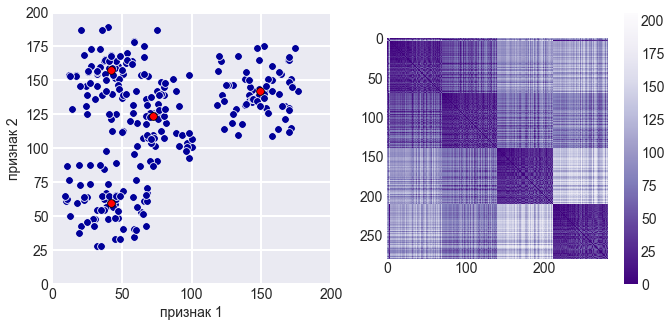

In [189]:
def genclust(nclust, size, numb): # Создаёт вектор точек с заданным количеством скоплений
    dots = np.zeros(numb * 2).reshape(numb, 2)
    rf = size // 6 # Максимальный радиус кластера
    for i in range(nclust):
        r = 1 # Начальный радиус кластера
        randx = np.random.random_integers(rf, size - rf + 1) # Случайно выбираем центр кластера
        randy = np.random.random_integers(rf, size - rf + 1)
        dots[i] = [randx, randy]
        for j in range((nclust if i == 0 else 0) + (numb // nclust) * i, (numb // nclust) * (i + 1)):
            dots[j] = [randx + np.random.random_integers(-r, r), randy + np.random.random_integers(-r, r)]
            if r < rf: # Выше генерируем примерно numb // nclust точек в радиусе текущей точки скопления
                r += 1 # Чтобы скопления точек были менее однородны, радиус кластера постепенно увеличивается
    return dots

np.random.seed(10)

# Задаваемые параметры

nclustgen = 4 # Количество кластеров для генерации
nclustfind = 4 # Количество кластеров для поиска
sizem = 200 # Границы выборки
k = 1.4 # Коэффициент скопления точек (количество / площадь)
numb = int(sizem * k) # Количество точек

dots = genclust(nclustgen, sizem, numb)

# Вывод

plt.figure(figsize=(17, 5))

plt.subplot(131)
plt.scatter(dots[:, 0], dots[:, 1], s=60,
            color='#000099', edgecolors='white', linewidth=0.8)

# Красным обозначены центры скопления
plt.scatter(dots[:nclustgen, 0], dots[:nclustgen,1], s=60,
            color='red', edgecolors='black', linewidth=0.8)

plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([0, sizem])
plt.ylim([0, sizem])

D = (dots[:,0][:, np.newaxis] - dots[:,0]) ** 2
D += (dots[:,1][:, np.newaxis] - dots[:,1]) ** 2
D = np.sqrt(D)

plt.subplot(132)
plt.imshow(D, cmap='Purples_r')
plt.colorbar(orientation='vertical', pad=0.06);

Матрица расстояний изначально упорядочена в силу метода генерации кластеров.

## Кластеризация с посощью K-means

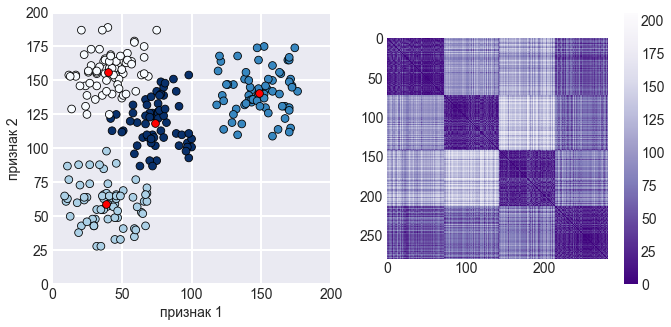

In [190]:
def dist(a, b): # Расстояние между двумя точками
    return int(sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2))

def cluster(dots, nclust, clusters): # Разбивает вектор точек на заданное количество кластеров
    prev = deepcopy(clusters[:1, :]) # Сохраняем координаты центроидов
    cdots = np.zeros(len(dots))
    for k, i in enumerate(dots): # Каждой точке ставим в соответствие центроид
        mind = 201
        for h, j in enumerate(clusters): # Находим ближайший центроид
            if dist(i, j) < mind:
                mind = dist(i, j)
                minj = h
        cdots[k] = minj
    for k, i in enumerate(cdots): # Накапливаем количество точек, принадлежащих к одному центроиду, и сумму их координат
        clusters[int(i)][2] += 1; # по x и по y соответственно
        clusters[int(i)][3] += dots[k][0]
        clusters[int(i)][4] += dots[k][1]
    for i in range(len(clusters)): # Вычисляем цент масс для точек, принадлежащих к одному центроиду
        if clusters[i][2] != 0: # Придаём эти новые координаты центроиду
            clusters[i][0] = clusters[i][3] // clusters[i][2]
            clusters[i][1] = clusters[i][4] // clusters[i][2]
        clusters[i][2] = clusters[i][3] = clusters[i][4] = 0 # Обнуляем все суммы для следующего шага
    if (prev == clusters[:1, :]).all(): # Если координаты центроидов не изменились, то завершаем процесс
        return cdots # В этом векторе хранятся отношения между точками и центроидами, к которым они принадлежат
    else:
        return cluster(dots, nclust, clusters) # Иначе продолжаем рекурсивно вычислять координаты центроидов
    
# Создаём матрицу, содержащую координаты центроидов и некоторые служебные поля (необходимы для передачи данных в рекурсии)
  
def gen_centroids(nclustfind, sizem):
    clusters = np.zeros(nclustfind * 5).reshape(nclustfind, 5)
    for i in range(0, nclustfind):
        clusters[i] = [np.random.random_integers(0, sizem + 1), np.random.random_integers(0, sizem + 1), 0, 0, 0]
    return clusters

clusters = gen_centroids(nclustfind, sizem)
        
cdots = cluster(dots, nclustfind, clusters)


# Вывод
    
plt.figure(figsize=(17, 5))

plt.subplot(131)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)

# Красным обозначены центроиды

plt.scatter(clusters[:, 0], clusters[:,1], s=60,
            color='red', edgecolors='black', linewidth=0.8)
    
plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([0, sizem])
plt.ylim([0, sizem])

i  = np.argsort(cdots)
dots2 = dots[i, :]

D = (dots2[:,0][:, np.newaxis] - dots2[:,0]) ** 2
D += (dots2[:,1][:, np.newaxis] - dots2[:,1]) ** 2
D = np.sqrt(D)

plt.subplot(132)
plt.imshow(D, cmap='Purples_r')
plt.colorbar(orientation='vertical', pad=0.06);

В данной реализации я использовал случайные начальные позиции для центроидов.

Алгоритм выполнил свою работу, расстановка цетроидов почти идентична исходной, в матрице расстояний достаточно легко выделить четыре класса, на этот раз они видны даже лучше, чем в начальном состоянии.

## Примеры

(0, 200)

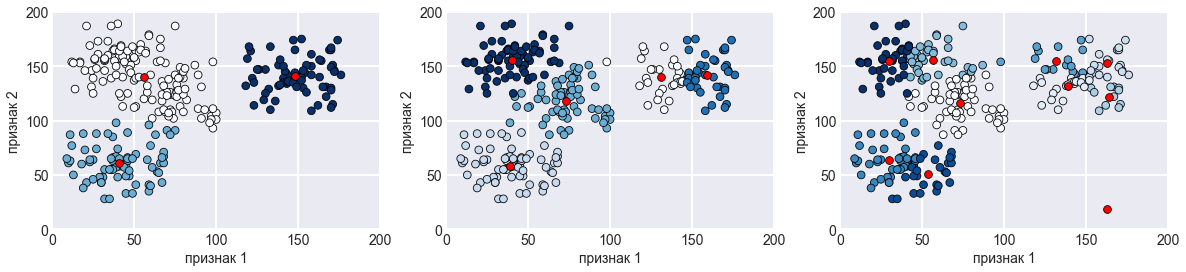

In [191]:
# Задаваемые параметры

sizem = 200 # Границы выборки
nclustgen = 4 # Количество кластеров для генерации
k = 1.4 # Коэффициент скопления точек (количество / площадь)
numb = int(sizem * k) # Количество точек

# Количество кластеров для поиска
nclustfind11 = 3 
nclustfind12 = 5 
nclustfind13 = 10 


# Генерируем выборку
dots1 = genclust(nclustgen, sizem, numb)

# Пример 1.1

clusters11 = gen_centroids(nclustfind11, sizem)
    
cdots11 = cluster(dots, nclustfind11, clusters11)


# Пример 1.2
clusters12 = gen_centroids(nclustfind12, sizem)

cdots12 = cluster(dots, nclustfind12, clusters12)


# Пример 1.3
clusters13 = gen_centroids(nclustfind13, sizem)

cdots13 = cluster(dots, nclustfind13, clusters13)

# Вывод

plt.figure(figsize=(20, 4))

plt.subplot(131)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots11, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)

# Красным обозначены центроиды

plt.scatter(clusters11[:, 0], clusters11[:,1], s=60,
            color='red', edgecolors='black', linewidth=0.8)

plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([0, sizem])
plt.ylim([0, sizem])

plt.subplot(132)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots12, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)

# Красным обозначены центроиды

plt.scatter(clusters12[:, 0], clusters12[:,1], s=60,
            color='red', edgecolors='black', linewidth=0.8)

plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([0, sizem])
plt.ylim([0, sizem])

plt.subplot(133)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots13, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)

# Красным обозначены центроиды

plt.scatter(clusters13[:, 0], clusters13[:,1], s=60,
            color='red', edgecolors='black', linewidth=0.8)

plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([0, sizem])
plt.ylim([0, sizem])

Во всех примерах алгоритм успешно справился с задачей, в случае же, когда количество сгенерированных кластеров совпадает с количеством искомых, центроиды занимают практически те же позиции, что и при генерации. 

Но стоит помнить об исключительной ситуации, когда центроид находится слишком далеко от какого-либо скопления точек. Тогда мы можем потерять несколько кластеров, однако алгоритм выдаст вполне корректный результат. 

Также нужно понимать, что k-means показывает такой хороший результат на заранее сгенерированных для этого данных. Будь структура более комплексной, или если её нельзя будет задать в виде крупных скоплений точек, k-means скорее всего провалится.

Добавлю, что k-means хорошо работает с монотонно заполненным полем или боллее разреженным скоплением точек, это можно заметить в примере с 10-ю центроидами, где отдельное скопление точек можно понимать как структуры такого рода.

(-5, 5)

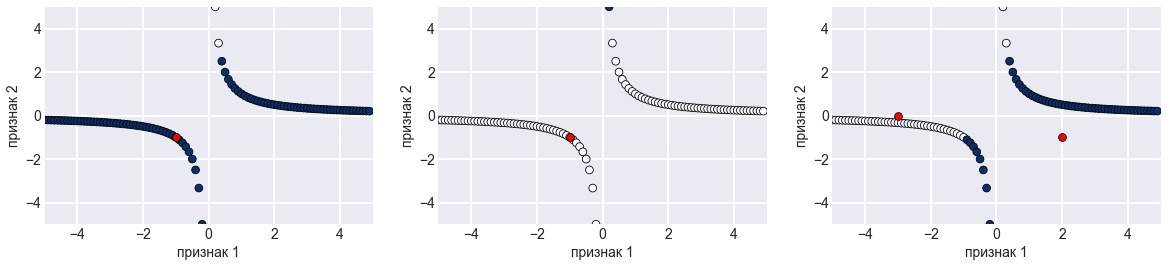

In [192]:
def make_gip(xmin, xmax, dx, sizem, const=0):
    xlist = np.around(np.arange(xmin, xmax, dx), decimals=4)

    ylist = 1 / xlist + const

    ylist[len(xlist) // 2] = sizem + 1 

    dots = np.zeros(len(xlist) * 2).reshape(len(xlist), 2)
    for i in range(len(xlist)):
        dots[i][0] = xlist[i]
        dots[i][1] = ylist[i]
    return dots

# Задаваемые параметры

sizem = 10 # Границы выборки
nclustfind = 2 # Количество кластеров для поиска


# Размер и плотность гиперболы
xmin = -(sizem // 2)
xmax = sizem // 2
dx = 0.1


dots = make_gip(xmin, xmax, dx, sizem)

# Пример 2.1

clusters21 = gen_centroids(nclustfind, sizem)
    
cdots21 = cluster(dots, nclustfind, clusters21)


# Пример 2.2
clusters22 = gen_centroids(nclustfind, sizem)

cdots22 = cluster(dots, nclustfind, clusters22)


# Пример 2.3
clusters23 = gen_centroids(nclustfind, sizem)

cdots23 = cluster(dots, nclustfind, clusters23)

# Вывод

plt.figure(figsize=(20, 4))

plt.subplot(131)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots21, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)

# Красным обозначены центроиды

plt.scatter(clusters21[:, 0], clusters21[:,1], s=60,
            color='red', edgecolors='black', linewidth=0.8)

plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

plt.subplot(132)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots22, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)

# Красным обозначены центроиды

plt.scatter(clusters22[:, 0], clusters22[:,1], s=60,
            color='red', edgecolors='black', linewidth=0.8)

plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

plt.subplot(133)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots23, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)

# Красным обозначены центроиды

plt.scatter(clusters23[:, 0], clusters23[:,1], s=60,
            color='red', edgecolors='black', linewidth=0.8)

plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

Гиперболу же при таком способе выбора центроидов удалось парвильно кластеризовать лишь один из трёх раз. Очевидно, что результат будет схожим в случаях с несколькими прямыми, с окружностями, со всевозможными палиномами и т.д. 

## k-means++

(-5, 5)

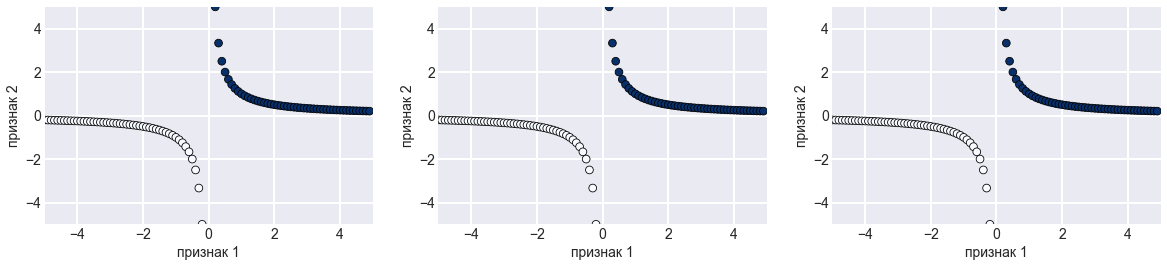

In [193]:
from sklearn.cluster import KMeans

# Используем алгоритм выбора цетроидов k-means++, котрый заключается в размещении следующего центроида удалённо от всех предыдущих.
cdots31 = KMeans(n_clusters=2, random_state=1, init='k-means++').fit_predict(dots)
cdots32 = KMeans(n_clusters=2, random_state=2, init='k-means++').fit_predict(dots)
cdots33 = KMeans(n_clusters=2, random_state=3, init='k-means++').fit_predict(dots)

# Вывод

plt.figure(figsize=(20, 4))

plt.subplot(131)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots31, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)


plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

plt.subplot(132)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots32, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)


plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

plt.subplot(133)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots33, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)


plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

При использовании k-means++ алгоритм уверенно кслассифицирует гиперболу, этому способствует то, что за начальную позицию центроида принимается одна из точек, а также центроиды стараются разместить как можно дальше друг от друга (чем дальше точка от ближайшего центроида, тем выше шанс выбора этой начальной позиции).

## Вывод

(-5, 5)

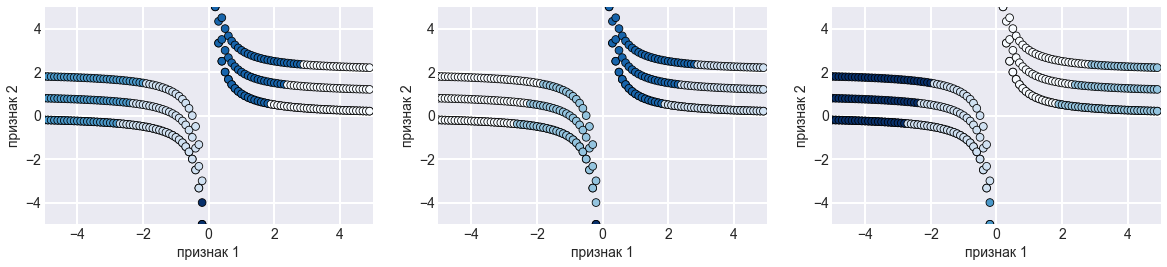

In [194]:
xmin = -(sizem // 2)
xmax = sizem // 2
dx = 0.1

# Генерируем три сдвинутых гиперболы
for i in range(3):
    dots = np.concatenate([dots, make_gip(xmin, xmax, dx, sizem, const=i)])
    
cdots41 = KMeans(n_clusters=6, random_state=1, init='k-means++').fit_predict(dots)
cdots42 = KMeans(n_clusters=6, random_state=2, init='k-means++').fit_predict(dots)
cdots43 = KMeans(n_clusters=6, random_state=3, init='k-means++').fit_predict(dots)

# Вывод

plt.figure(figsize=(20, 4))

plt.subplot(131)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots41, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)


plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

plt.subplot(132)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots42, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)


plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

plt.subplot(133)
plt.scatter(dots[:, 0], dots[:, 1],
        c=cdots43, s=60, cmap='Blues',
        edgecolors='black', linewidth=0.8)


plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

Но даже этот метод выбора центроидов способен работать только со специальным видом данных. Сама реализация не предполагает отделения друг от друга парралельных линий или близких отрезков/кривых.

Алгоритм k-means применим только к данным с большими скоплениями точек, которые либо однородны ("кучки"/монотонно заполненное поле), либо находятся на достаточно большом расстоянии друг от друга(две ветви гиперболы, удалённые непересекающиеся линии).